# Waterfall Plot  

The following demonstrates how to create a waterfall plot in the style of teh DAFX book.

## References
- Chapter 4.3 in: Zölzer, U., Amatriain, X., Arfib, D., Bonada, J., De Poli, G., Dutilleux, P., ... & Todoroff, T. (2002). DAFX-Digital audio effects. John Wiley & Sons.
- https://matplotlib.org/stable/gallery/mplot3d/polys3d.html#sphx-glr-gallery-mplot3d-polys3d-py
- https://stackoverflow.com/questions/30223161/matplotlib-mplot3d-how-to-increase-the-size-of-an-axis-stretch-in-a-3d-plo

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Create a signal that changes it spectrum

We use a sine wave that get more and more amplified over time (0.5 sec) going through a distortion.

In [2]:
f = lambda x: sign(x)*(1-exp(-abs(x))) #distortion function

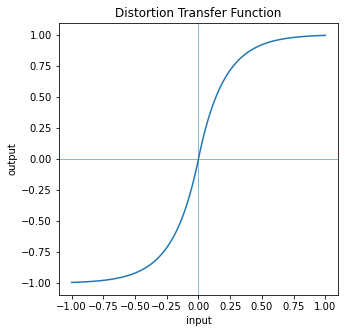

In [3]:
figure(figsize=[5,5])
x = linspace(-1,1, 100)
plot(x,f(x*5))
axhline(lw=0.5)
axvline(lw=0.5)
title('Distortion Transfer Function')
xlabel('input')
ylabel('output')
show()

### Setup of Simulation Parameters 

In [19]:
T = 20
sr = 44100
N = int(T*sr)
ns = arange(N)
t = ns/sr

### Sine wave generation

In [5]:
#amp = 10**(linspace(-50,0,N)/20) #amplitude 'envelope'
amp = linspace(0, 1, N)
f0 = 1000 #[Hz], fundamental frequency
x = sin(2*pi*t*f0)

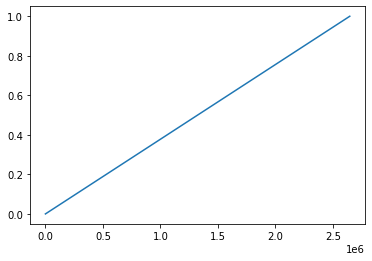

In [6]:
plot(amp)

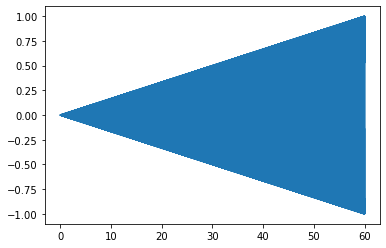

In [7]:
plot(t,x*amp)

In [8]:
y = f(x*amp) #distorting the sine wave

In [9]:
def apLTI(x, M, g):
    
    y = zeros_like(x)
    v = zeros_like(x)

    for n in range(N):
        
        v[n] = x[n] - g[n] * v[n-M]  
        y[n] = v[n-M] + v[n] * g[n]
        
    return y



def apA(x, M, g):
    
    y = zeros_like(x)
    v = zeros_like(x)
    w = zeros_like(x)
    T1 = zeros_like(x)
    T2 = zeros_like(x)

    for n in range(N):
        T1[n] = sqrt((1-g[n])/(1+g[n]))
        T2[n] = sqrt((1+g[n])/(1-g[n]))

        v[n] = x[n] - w[n-M]* T2[n]
        w[n] = (x[n] + g[n] * v[n]) * T1[n]
        y[n] = g[n] * v[n] + w[n-M]* T2[n]
        
    return y

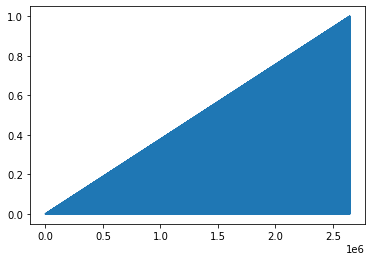

In [10]:
M = 1 #Delaytime
g = zeros_like(x)
g = x * amp #Attenuated Input Signal controls the Allpass-Gain


y = apLTI(x, M, g) #Modulated Allpassfilter

plot(abs(g))

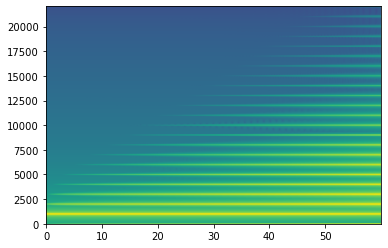

In [12]:
s, freq, st,_ = specgram(y,NFFT=1024,noverlap=0,Fs=sr,)

In [13]:
numTimeSamples = 20 #number of polygons to plot / time instants to extract from spectrogram.

In [14]:
spec = fft.fft(y, norm='forward')[0:513]

In [15]:
import scipy.signal as sig
spec = sig.periodogram(y, fs=sr,nfft=8096*12)

In [16]:
from matplotlib.collections import PolyCollection

In [17]:
def _polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    Needed for waterfall plot.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]


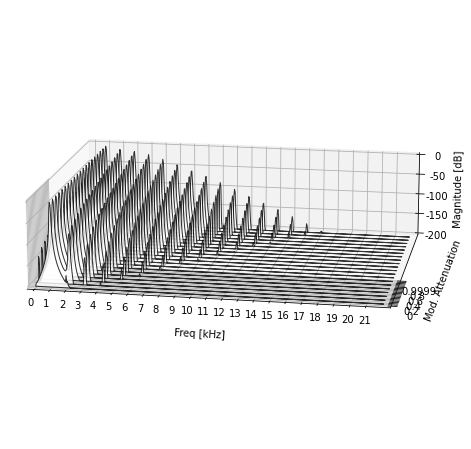

In [18]:
# amplitude scaling/normalization to avoid polygons going through 0.
mags = 20*log10(s)
minAmp = np.min(mags)
spanOfInterest = 200 #dB
a = mags-minAmp
newMax = np.max(a)
minLim = newMax-spanOfInterest
mags = clip(a, minLim, 9999)-minLim

stN = 10**(linspace(-50,0,st.shape[0])/20)


# ---Vertex creation--------
# For explanations of the following refer to: https://matplotlib.org/stable/gallery/mplot3d/polys3d.html#sphx-glr-gallery-mplot3d-polys3d-py 
verts = [_polygon_under_graph(freq, mags[:,tim]) for tim in (arange(numTimeSamples)*(len(stN)/numTimeSamples)).astype(np.int32)]
# --------------------------

fig = plt.figure(figsize=plt.figaspect(0.5)*2)#[50,5])
ax = fig.add_subplot(projection='3d')

# --Polygon coloring----
facecolors = ['w']
#  use the above or use matplotlib's colormaps to give each polygon a different color:
# facecolors = plt.colormaps['hsv'](np.linspace(0, 1, len(verts)))
# ----------------------

poly = PolyCollection(verts, facecolors=facecolors, alpha=0.8,edgecolors=['k'])
ax.add_collection3d(poly, zs=arange(numTimeSamples)*(T/numTimeSamples), zdir='y')

# generate kHz ticklabels
flabels = arange(floor((sr/2)/1000), dtype=np.int8)
fticks = flabels*1000

tticks = array([0,'','','',0.2,'','','',0.4,'','', '',0.6,'','','',0.8,'','','', 0.9999])


ax.set(xlim=(0, sr/2), 
       ylim=(0, T),
       yticks = flabels[:21],
       yticklabels = tticks,
       xticks =  fticks,
       xticklabels= flabels,
       zlim=(0, spanOfInterest),
       zticks =  linspace(0,spanOfInterest, 5),
       zticklabels=linspace(-spanOfInterest,0, 5,dtype=np.int16),
        ylabel='Mod. Attenuation', zlabel='Magnitude [dB]')

ax.set_xlabel('\n' + 'Freq [kHz]', linespacing=4)

ax.set_box_aspect(aspect = (20,15,5))
ax.view_init(elev=15., azim=-80) #3d Cam position

plt.show()